<a href="https://colab.research.google.com/github/ecsquare/Deep-Compression-with-autoencoder/blob/master/Compression_with_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In addition to the implementation of deep encoder we will study the effect of different distorsions and noise on the training of this model. In our case we will study two types of noise 


1.   Salt & pepper
2.   Speckle



In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import math
from skimage.metrics import structural_similarity as ssim

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

<h1> 1-Data processing </h1>

Load the MNIST Dataset

In [0]:
from keras.datasets import mnist
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
X_test.shape

(10000, 28, 28)

In [0]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
# Normalisation
X_train /= 255
X_test /= 255

<h1> 2.Build Deep autoencoder model <h1>

In [0]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

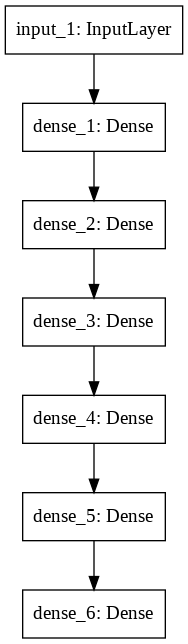

In [9]:
plot_model(autoencoder, to_file='model.png')

<h1> 3-Training the model </h1>

<h2> 3.1-Training on original dataset </h2>




In [0]:
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/checks_autoencoder/model-{epoch:02d}.hdf5', verbose=1)
callbacks_list=[checkpointer]
autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=callbacks_list)

Plot training & validation loss values


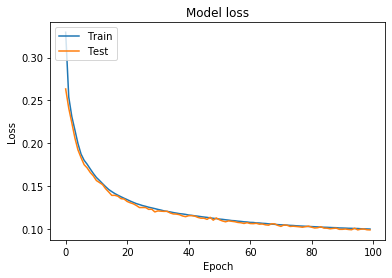

In [11]:
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [0]:
autoencoder.load_weights('/content/gdrive/My Drive/Colab Notebooks/checks_autoencoder/model-100.hdf5')

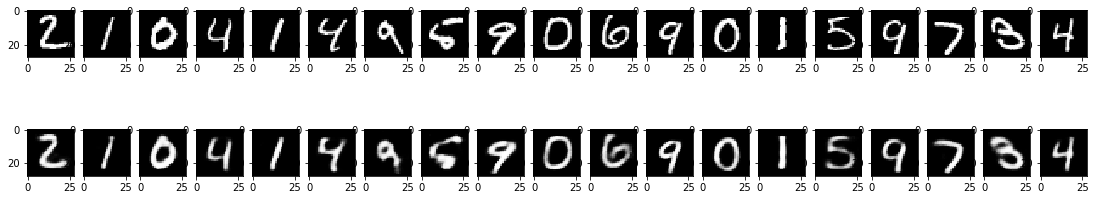

In [17]:
decoded_imgs = autoencoder.predict(X_test)
n = 20
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)


    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
   
plt.show()

#PSNR
Peak signal-to-noise ratio its the way to refer at the maximun difference between an original signal and its noise-affected version


In [0]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

[63.30618644671929, 61.85340964318647, 64.05035827619407, 62.13908073651898, 63.73143241006232, 65.21357436494338, 62.11497468838617, 62.907818908325694, 62.500393604574796, 62.13605287992212, 62.67049147538704, 61.833133599019504, 62.96694424833795, 63.69278324027355, 65.4103803973934, 63.37347310048099, 62.12854140553362, 61.9289389152069, 60.44455744875698, 64.3230878289731]


<BarContainer object of 20 artists>

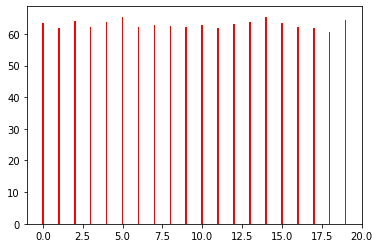

In [64]:
d1=[]
for i in range(20):
    d1.append(psnr(X_test[i],decoded_imgs[i]))
print(d1)
plt.bar(range(20),d1, width = 0.1, color = 'red')


[0.5448625805717154, 0.5937826233317817, 0.4618239292817592, 0.750794520129803, 0.6088102938744193, 0.6139516344319963, 0.5919498019976996, 0.4604779892730737, 0.6281839407140858, 0.6319081544514628, 0.6979693321622809, 0.6538439570051008, 0.5364985042764064, 0.7428476693971219, 0.5555845783263549, 0.5834290228640162, 0.5810652442519469, 0.42677948631432916, 0.5801983257804821, 0.6749003979765359]


<BarContainer object of 20 artists>

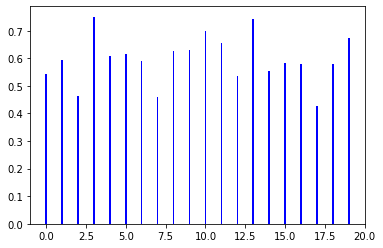

In [56]:
s1=[]
for i in range(20):
    img1=X_test[i]
    image=decoded_imgs[i]
    ss=ssim(img1,image, data=img1.max()-image.min())
    s1.append(ss)
print(s1)
plt.bar(range(20),s1, width = 0.1, color = 'Blue')


<h2> 3-2 Training on dataset+ noise Salt&pepper <h2>

But first what is salt&pepper noise? <br>
Salt-and-pepper also known as impulse noise. This noise can be caused by sharp and sudden disturbances in the image signal. It presents itself as sparsely occurring white and black pixels.





In [0]:
def saltpepper_noise(arr,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(784)
    thres = 1 - prob 
    for i in range(784):
        rdn = random.random()
        if rdn < prob:
          output[i] = 0
        elif rdn > thres:
          output[i] = 1
        else:
          output[i] = arr[i]
    return output

Add noise to the dataset

In [0]:
def prepare_data_salt_pepper(data,prob):
  output = np.zeros(data.shape)
  for i in range(len(data)):
    output[i]=saltpepper_noise(data[i],prob)
  return output

Prepare train and test dataset with p=0.1

In [0]:
X_train_salt_pepper=prepare_data_salt_pepper(X_train,0.1)
X_test_salt_pepper=prepare_data_salt_pepper(X_test,0.1)

Let's see some dataset elements before and after noise 


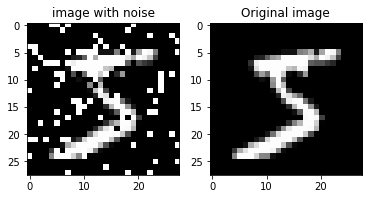

In [30]:
plt.subplot(121)
plt.imshow(X_train_salt_pepper[0].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title("image with noise")
 
plt.subplot(122)
plt.imshow(X_train[0].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title("Original image")

# Show the graph
plt.show()

Train the model with this new data

In [0]:
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/checks_autoencoder_salt_pepper/model-{epoch:02d}.hdf5', verbose=1)
callbacks_list=[checkpointer]
autoencoder.fit(X_train_salt_pepper, X_train_salt_pepper,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_salt_pepper, X_test_salt_pepper),
                callbacks=callbacks_list)


Show some predictions

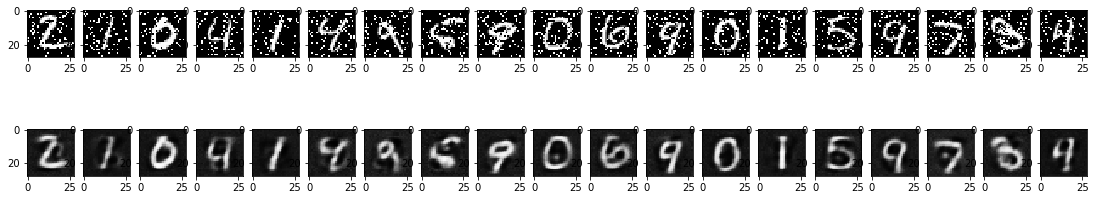

In [33]:
decoded_imgs1 = autoencoder.predict(X_test_salt_pepper)
n = 20
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_salt_pepper[i].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)


    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs1[i].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
   
plt.show()

[58.69278405961823, 58.16277710983034, 58.69102348698622, 59.38227015597704, 58.33613596455596, 59.32701172977315, 58.07931720000405, 57.757988358505955, 58.33280951243423, 57.961213114314475, 58.2259320589958, 58.123800242226274, 58.36837125314035, 59.092652111297724, 58.49233423064335, 58.41884368065724, 58.59844790370296, 57.59515756779056, 57.67271032158235, 59.047357992639824]


<BarContainer object of 20 artists>

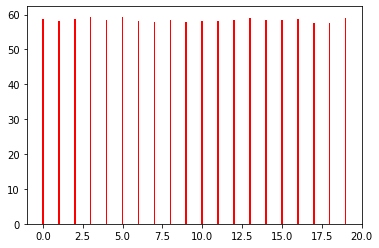

In [65]:
d2=[]
for i in range(20):
    d2.append(psnr(X_test_salt_pepper[i],decoded_imgs1[i]))
print(d2)
plt.bar(range(20),d2, width = 0.1, color = 'red')

[0.1796143558762435, 0.20290586498551025, 0.15580971312023997, 0.3077361632071913, 0.23142983643875084, 0.19651765303335725, 0.1986035116855626, 0.15520674351079933, 0.17696236887111613, 0.20058891057756395, 0.2607091644761844, 0.23053544746245194, 0.22344973204185345, 0.3014188372167666, 0.18063021007320493, 0.1782652765344163, 0.2408428071778405, 0.15927069205553104, 0.1802772343416894, 0.22464612983519555]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """


<BarContainer object of 20 artists>

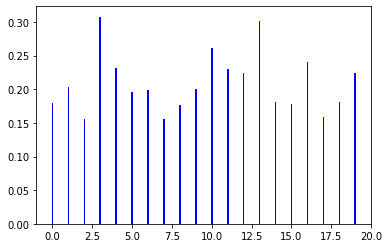

In [57]:
s2=[]
for i in range(20):
    img1=X_test_salt_pepper[i]
    image=decoded_imgs1[i]
    ss=ssim(img1,image, data=img1.max()-image.min())
    s2.append(ss)
print(s2)
plt.bar(range(20),s2, width = 0.1, color = 'Blue')

<h2> 3-3 Training on dataset+ noise Speckle <h2>




Same thing here. Let's start with presenting Speckle noise. <br>
Speckle noise is defined as multiplicative noise, having a granular pattern it is the inherent property of SAR image. Synthetic Aperture Radar (SAR) imagery uses microwave radiation so that it can illuminate the earth surface. Synthetic Aperture Radar provides its own illumination.

In [0]:
def speckle_noise(arr):
      gauss = np.random.randn(784)      
      noisy = arr + arr * gauss
      return noisy

Add noise to dataset

In [0]:
def prepare_data_speckle(data):
  output = np.zeros(data.shape)
  for i in range(len(data)):
    output[i]=speckle_noise(data[i])
    m=output[i].max()
    output[i]=output[i]/m
  return output

Prepare train and test

In [0]:
X_train_speckle=prepare_data_speckle(X_train)
X_test_speckle=prepare_data_speckle(X_test)

Plot some pictures showing the original and noisy images

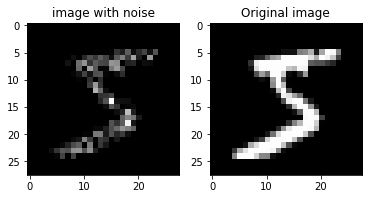

In [43]:
plt.subplot(121)
plt.imshow(X_train_speckle[0].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title("image with noise")
 
 
plt.subplot(122)
plt.imshow(X_train[0].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title("Original image")

# Show the graph
plt.show()

Train the model on the new data

In [0]:
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/checks_autoencoder_speckle/model-{epoch:02d}.hdf5', verbose=1)
callbacks_list=[checkpointer]
autoencoder.fit(X_train_speckle, X_train_speckle,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_speckle, X_test_speckle),
                callbacks=callbacks_list)

Plot training & validation loss values


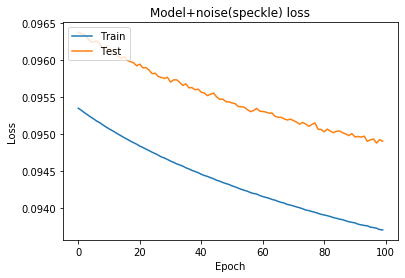

In [47]:
a=autoencoder.history.history['loss']
b=autoencoder.history.history['val_loss']
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Model+noise(speckle) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Try some predictions

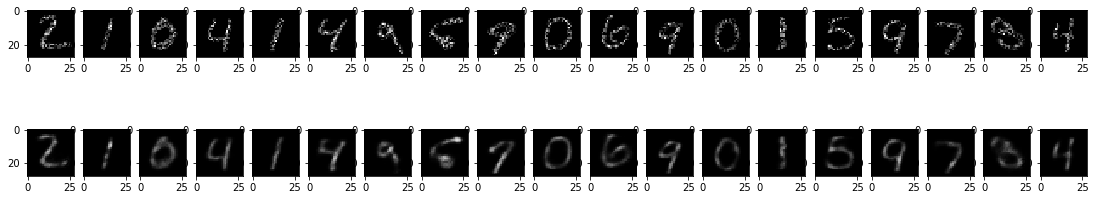

In [49]:
decoded_imgs2 = autoencoder.predict(X_test_speckle)
n = 20
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_speckle[i].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)


    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs2[i].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
   
plt.show()

[58.69278405961823, 58.16277710983034, 58.69102348698622, 59.38227015597704, 58.33613596455596, 59.32701172977315, 58.07931720000405, 57.757988358505955, 58.33280951243423, 57.961213114314475, 58.2259320589958, 58.123800242226274, 58.36837125314035, 59.092652111297724, 58.49233423064335, 58.41884368065724, 58.59844790370296, 57.59515756779056, 57.67271032158235, 59.047357992639824]


<BarContainer object of 20 artists>

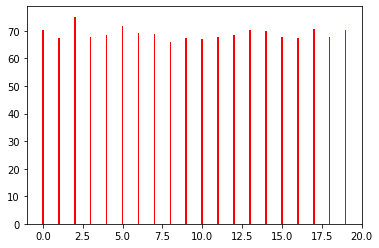

In [66]:
d3=[]
for i in range(20):
    d3.append(psnr(X_test_speckle[i],decoded_imgs2[i]))
print(d2)
plt.bar(range(20),d3, width = 0.1, color = 'red')

[0.8584958195090826, 0.7747225468168778, 0.9242726374399046, 0.775797904886458, 0.8102579925622843, 0.8895037435435633, 0.8169985805246889, 0.8105185910469324, 0.7532621823682719, 0.799044462903851, 0.7435881213093257, 0.7296414607910062, 0.8242505514696402, 0.7873046961937641, 0.8718867348009154, 0.7466396738234675, 0.8412167343728846, 0.8358681376742826, 0.7087802487332228, 0.8394991863198854]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """


<BarContainer object of 20 artists>

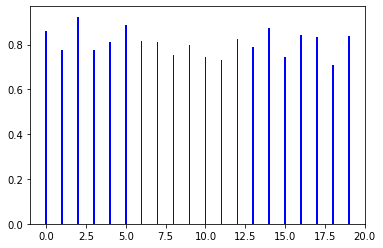

In [55]:
s3=[]
for i in range(20):
    img1=X_test_speckle[i]
    image=decoded_imgs2[i]
    ss=ssim(img1,image, data=img1.max()-image.min())
    s3.append(ss)
print(s3)
plt.bar(range(20),s3, width = 0.1, color = 'Blue')

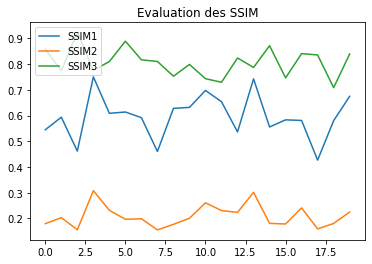

In [68]:
plt.plot(s1)
plt.plot(s2)
plt.plot(s3)
plt.title('Evaluation des SSIM')
plt.legend(['SSIM1', 'SSIM2','SSIM3'], loc='upper left')
plt.show()

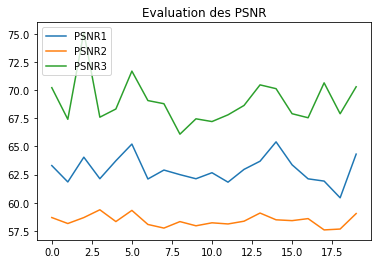

In [67]:
plt.plot(d1)
plt.plot(d2)
plt.plot(d3)
plt.title('Evaluation des PSNR')

plt.legend(['PSNR1', 'PSNR2','PSNR3'], loc='upper left')
plt.show()